In [57]:
import tensorflow as tf
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

In [58]:
images_path = "train_images"
masks_path = "train_masks"

def load_images_from_folder(folder, target_size=(64, 64), binary=True):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img.astype('float32') / 255.0  # Normalize to [0, 1]
            if binary:
                img = (img > 0.5).astype('float32')  # Enforce binary mask
            img = np.expand_dims(img, axis=-1)  # Shape: (H, W, 1)
            images.append(img)
    return np.array(images)


all_images = load_images_from_folder(images_path, binary=False)
all_masks = load_images_from_folder(masks_path, binary=True)



In [59]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, shuffle=True, random_state=42
)

In [60]:

def conv_block(inputs, out_channels):
    x = tf.keras.layers.Conv2D(out_channels, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(out_channels, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def encoder_block(inputs, out_channels):
    x = conv_block(inputs, out_channels)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, out_channels):
    x = tf.keras.layers.Conv2DTranspose(out_channels, (2, 2), strides=2, padding="same")(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, out_channels)
    return x

def build_unet(input_shape=(512, 512, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(inputs, outputs)

In [ ]:
#import dice loss
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

model = build_unet(input_shape=(64, 64, 1))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])
model.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), epochs=10, batch_size=64)
results = model.evaluate(val_imgs, val_masks)
print(f"Validation Loss: {results[0]}, Validation Accuracy: {results[1]}")



Epoch 1/10
12/27 ━━━━━━━━━━━━━━━━━━━━ 1:07 5s/step - accuracy: 0.5705 - loss: 1.4933

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


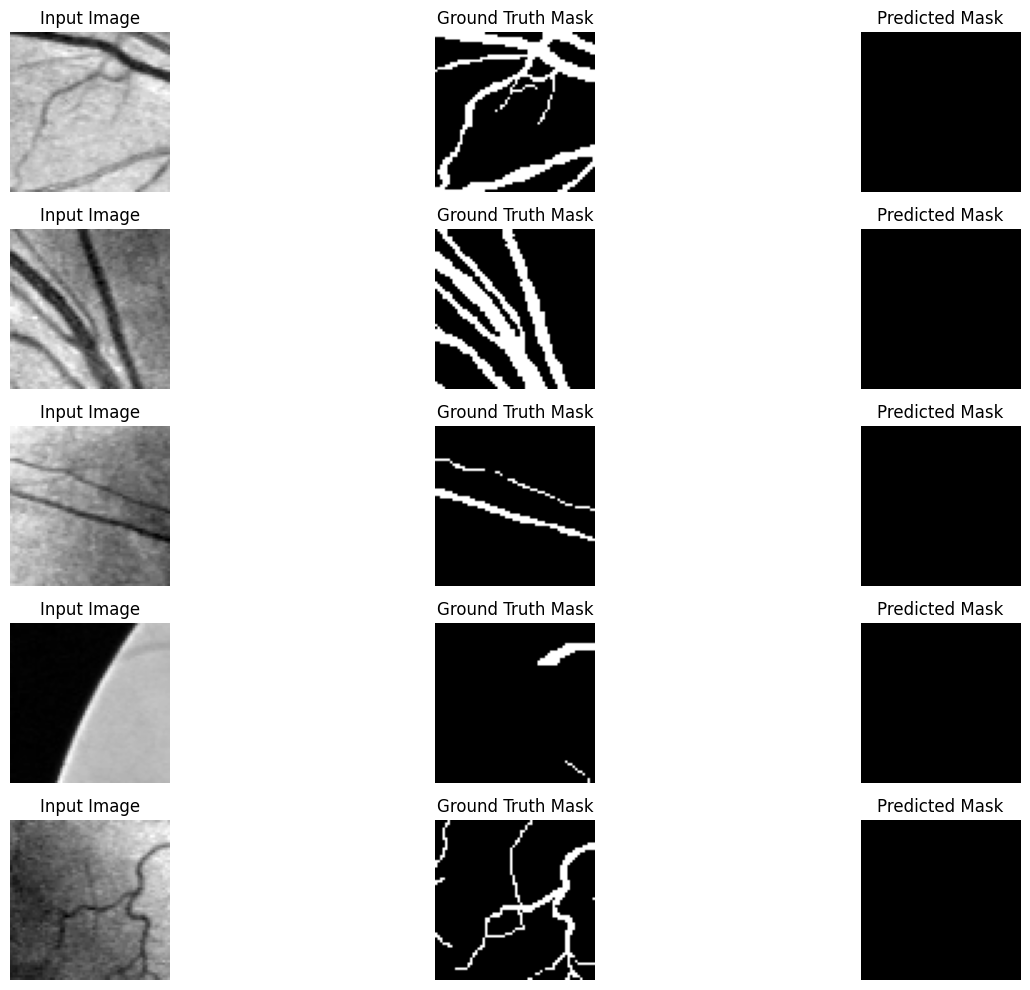

In [ ]:
# show model inputs with predictions
# import diceBCE 


def show_predictions(model, images, masks, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        mask = masks[idx]
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred = (pred > 0.5).astype(np.float32)
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pred.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
show_predictions(model, val_imgs, val_masks, num_images=5)